## 題目：[NCTS]作業11-1
### 使用VAE來做手寫辨識，
### 將最後的結果動態呈現出來，打造最好的呈現方式!

想想在encoder 找到兩張手寫數字 a, b 的 latent representation，

然後從代表 a 的 latent 到 代表 b 的 latent 拉一直線, 

把線段中代表的圖用 decoder 畫出來，

這個必須是動態的圖片變化，可參考上禮拜上課呈現出來中間那張圖的樣子

*模型權重可使用澤佑助教提供的

作業截止:5/24 9:00

### Assign Environment

In [144]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


### Import Relate Funtion

In [145]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

In [146]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

### Load Data

In [147]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)

There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


### Preprocessing Data

In [148]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

# Variational Autoencoder

若每筆資料的 latent 不僅僅是一個**位置**，

而是一個分布，且分布的平均值附近都要能還原

Variational Autoencoder 的結構如下：

<img src="VAE_model.png" alt="drawing" style="width: 800px;"/>

在此， Encoder 的作用不是將資料表示成 latent，而是將資料表示成常態分配的兩個參數，平均數與變異數。

而 Decoder 也不再直接使用 Encoder 的結果，而是將 Encoder 的結果作為常態抽樣的兩個參數來進行。

因此，資料經過 Encoder，會得到一適當大小的常態分配之參數，而 Decoder 則使用這組參數進行抽樣。

即使是同一筆資料，Decoder 每次接受到的 latent 表示法可能都不一樣 (但會在某個平均數附近)。

### Build VAE Model (激勵函數改relu)

In [149]:
enc_1 = Dense(100, activation='relu')

enc_mean = Dense(2)

enc_log_var = Dense(2)

dec_2 = Dense(100, activation='relu')
dec_1 = Dense(784, activation='sigmoid')

### Define 抽樣函數

In [150]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### Define Input and through layer

In [151]:
x = Input(shape=(784,))

In [152]:
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

### using Lambda to transform to Keras layer

In [153]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var]) #after sampling and output 2

In [154]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [155]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 100)          78500       input_3[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            202         dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 2)            202         dense_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (

### Visualize Model

import pydot

from keras.utils.vis_utils import plot_model

plot_model(VAE, to_file='Variational_Autoencoder_1.png')

 <img src="Variational_Autoencoder_1.png" alt="drawing" style="width: 200px;"/>

### Define Loss Function

In [156]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

### Compile and Train Model (optimizer用rmsprop / shuffle=True)

In [157]:
VAE.compile(loss=vae_loss, optimizer='rmsprop')
VAE.fit(x_train, x_train, shuffle=True, batch_size=32, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 4s 63us/step - loss: 183.5335
Epoch 2/100
60000/60000 [==============================] - 3s 58us/step - loss: 169.3212
Epoch 3/100
60000/60000 [==============================] - 4s 59us/step - loss: 166.3499
Epoch 4/100
60000/60000 [==============================] - 4s 59us/step - loss: 164.2569
Epoch 5/100
60000/60000 [==============================] - 4s 59us/step - loss: 162.5780
Epoch 6/100
60000/60000 [==============================] - 4s 60us/step - loss: 161.1855
Epoch 7/100
60000/60000 [==============================] - 4s 59us/step - loss: 160.1460
Epoch 8/100
60000/60000 [==============================] - 4s 59us/step - loss: 159.4164
Epoch 9/100
60000/60000 [==============================] - 3s 58us/step - loss: 158.7375
Epoch 10/100
60000/60000 [==============================] - 4s 58us/step - loss: 158.2277
Epoch 11/100
60000/60000 [==============================] - 3s 58us/step - loss: 157.8546
Epoch 12/100
60000/

60000/60000 [==============================] - 3s 58us/step - loss: 152.0532
Epoch 93/100
60000/60000 [==============================] - 3s 58us/step - loss: 152.0715
Epoch 94/100
60000/60000 [==============================] - 3s 58us/step - loss: 152.0274
Epoch 95/100
60000/60000 [==============================] - 3s 58us/step - loss: 152.0229
Epoch 96/100
60000/60000 [==============================] - 3s 58us/step - loss: 151.9912
Epoch 97/100
60000/60000 [==============================] - 3s 58us/step - loss: 151.9808
Epoch 98/100
60000/60000 [==============================] - 3s 58us/step - loss: 151.9714
Epoch 99/100
60000/60000 [==============================] - 3s 58us/step - loss: 152.0623
Epoch 100/100
60000/60000 [==============================] - 3s 58us/step - loss: 151.9427


In [158]:
score = VAE.evaluate(x_train, x_train, batch_size=10000)
print("Loss: %f" %score)

60000/60000 [==============================] - 1s 9us/step
Loss: 152.758532


### Extract Encoder and Decoder

In [159]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


### Define another h_input

In [160]:
h_input = Input(shape=(2,))

In [161]:
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_10 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


### Using Encoder to calculate random photo latent

In [162]:
idx = np.random.randint(x_train.shape[0])

print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 14713 圖的 latent 表示為 [[-0.86347026  0.6788217 ]]


### Using Encoder to transform random 3000 data to latents and plot

In [163]:
indices = np.random.randint(x_test.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

### Plot latents / cmap use tab20b 

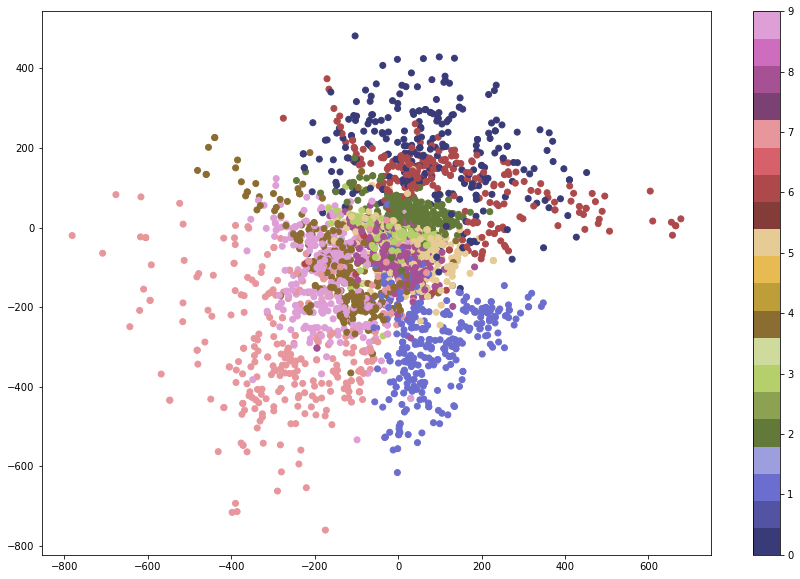

In [164]:
plt.figure(figsize=(15, 10))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], 
            c=y_test0[indices], cmap='tab20b') 
plt.colorbar()
plt.show()

### Using Decoder to Visualize

In [165]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [166]:
n = 20
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))

In [167]:
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

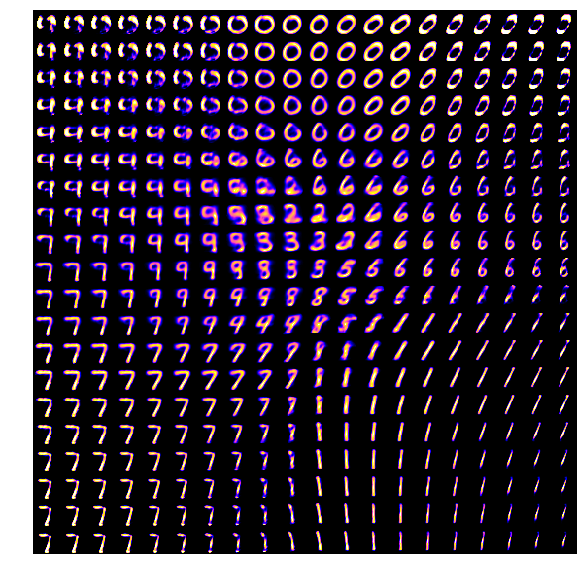

In [168]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='gnuplot2')
plt.axis('off')
plt.show()

# Dynamic compare Rusult

In [187]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

In [188]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='bone') #將中間的圖 變成黑底白字 較好看出變化 

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [189]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.05,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>

 <img src="VAE.png" alt="drawing" style="width: 500px;"/>